# Wave geometry model

Run the quasi-geostrophic wavegeometry model developed by Nili Harnik and collegues. The chosen wavennumber, frequency and zonal-mean basic state define a matrix equation that can be solved using linear algebra. A forcing defines the wave amplitude at the bottom of the domain. The model is closed at the top and at the equator by sponge layer of Rayleigh friction and Newtonina cooling.

Equation not finished yet.

$0 = \frac{f^2}{\rho}\frac{\partial}{\partial z}\left(\frac{\rho}{N^2}\frac{\partial\varphi}{\partial z}\right)
+ \frac{1}{\cos y}\frac{\partial}{\partial y}\left(\cos y\frac{\partial\varphi}{\partial y}\right)
- $

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

import scipy.sparse as sparse
import scipy.sparse.linalg as linalg

In [2]:
%cd /s2s/wwicker/wavegeometry_model/src
from basicstate import Grid
from anywave import Matrix
import anywave as wave

/s2s/wwicker/wavegeometry_model/src


In [3]:
# Input filenames
namelist = '/s2s/wwicker/wavegeometry_model/input/nml-IFS-pressure-level'
basicstate_file = '/s2s/wwicker/wavegeometry_model/input/IFS-pressure-level-91L.nc'

s = 1
gammac = 0.05
freq = -0.14 # angular frequency in days**(-1)


## Initialize and run the model

In [4]:
# Initialize model
grid = Grid(namelist)
matrix = Matrix(grid,s)

# Load basic state
basicstate = xr.open_dataset(basicstate_file)

basicstate

<xarray.Dataset>
Dimensions:  (lat: 181, lev: 71, step: 1)
Coordinates:
  * lat      (lat) float64 0.0 0.008727 0.01745 0.02618 ... 1.553 1.562 1.571
  * lev      (lev) float64 0.0 1.479e+03 2.958e+03 ... 1.02e+05 1.035e+05
  * step     (step) int32 0
Data variables:
    u        (step, lev, lat) float64 ...
    qy       (step, lev, lat) float64 ...
    N2       (step, lev, lat) float64 ...

(71, 181)


Text(0.5, 1.0, 'Sponge_layer')

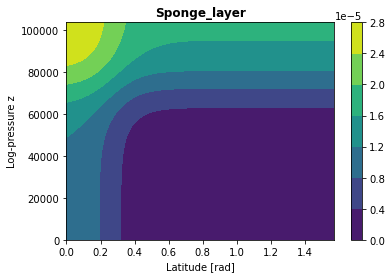

In [5]:
# Define sponge layer
damp = wave.damp(grid,basicstate['u'].values,s,gammac,freq)
rayd = wave.rayd(grid)
alpha = wave.alpha(grid)

print(rayd.shape)

ax = plt.axes()
C = ax.contourf(basicstate.lat,basicstate.lev,rayd)
ax.set_ylabel('Log-pressure z')
ax.set_xlabel('Latitude [rad]')
plt.colorbar(C)
ax.set_title('Sponge_layer',weight='bold')

In [6]:
# Run Model
f = matrix.forcing()
A = matrix.A(basicstate['qy'].values,
             basicstate['N2'].values,
             damp,
             rayd,
             alpha)

In [7]:
phi = matrix.solve(A,f)

phi.shape

(1, 71, 181)

## Plotting diagnostics

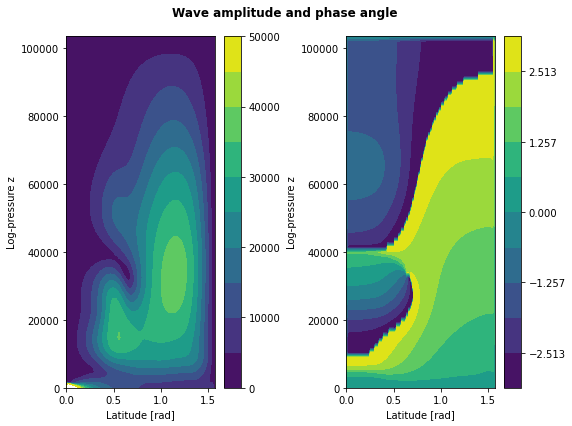

In [8]:
# Plot time-mean wave amplitude and phase
amplitude = wave.amplitude(grid,phi).mean(axis=0)
phase = wave.phase(grid,phi).mean(axis=0)

fig, axes = plt.subplots(1,2,figsize=(8,6))

# filled contours for amplitude
levels = np.linspace(0,50000,11)
C = axes[0].contourf(basicstate.lat,basicstate.lev,amplitude,levels=levels)
axes[0].set_ylabel('Log-pressure z')
axes[0].set_xlabel('Latitude [rad]')
plt.colorbar(C,ax=axes[0])

# filled contours for phase
levels = np.linspace(-np.pi,np.pi,11)
C = axes[1].contourf(basicstate.lat,basicstate.lev,phase,levels=levels)
axes[1].set_ylabel('Log-pressure z')
axes[1].set_xlabel('Latitude [rad]')
plt.colorbar(C,ax=axes[1])

fig.suptitle('Wave amplitude and phase angle',weight='bold')
fig.tight_layout()


plt_dir = '/s2s/wwicker/plots/wavegeometry_model/'
plt.savefig(plt_dir+'IFS-pressure-level-91L_wave_amplitude_phase.png',dpi=300)

/s2s/wwicker/wavegeometry_model/src/anywave.py:227: RuntimeWarning: divide by zero encountered in true_divide
  result = - np.real((grid._fyy(phi)-grid.sn/grid.cs*grid._fy(phi))/phi)
/s2s/wwicker/wavegeometry_model/src/anywave.py:227: RuntimeWarning: invalid value encountered in true_divide
  result = - np.real((grid._fyy(phi)-grid.sn/grid.cs*grid._fy(phi))/phi)
<ipython-input-9-d69354e364ef>:2: RuntimeWarning: invalid value encountered in sqrt
  l = np.sqrt(wave.l2(grid,phi)).mean(axis=0)
/s2s/wwicker/wavegeometry_model/src/anywave.py:238: RuntimeWarning: divide by zero encountered in true_divide
  result = - np.real(psizz/phi) * np.sqrt(grid.ez * N2)
/s2s/wwicker/wavegeometry_model/src/anywave.py:238: RuntimeWarning: invalid value encountered in true_divide
  result = - np.real(psizz/phi) * np.sqrt(grid.ez * N2)
<ipython-input-9-d69354e364ef>:3: RuntimeWarning: invalid value encountered in sqrt
  m = np.sqrt(wave.m2(grid,phi,basicstate['N2'].values)).mean(axis=0)
<ipython-input-9-d69

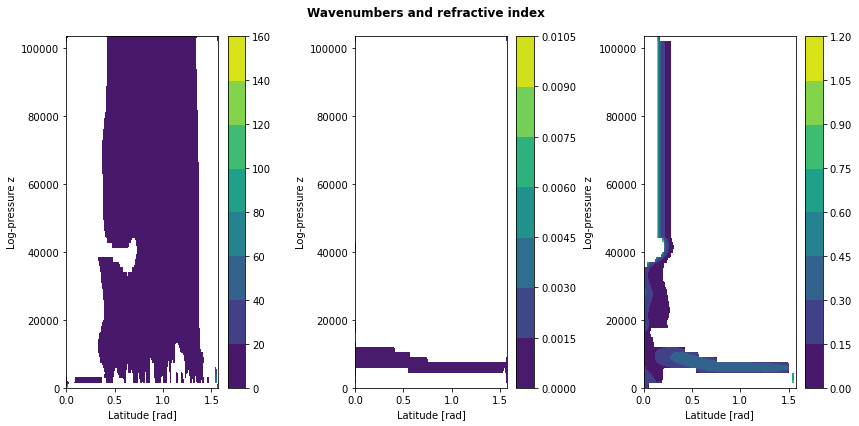

In [9]:
# Plot meridional and vertical wavenumber and refractive index
l = np.sqrt(wave.l2(grid,phi)).mean(axis=0)
m = np.sqrt(wave.m2(grid,phi,basicstate['N2'].values)).mean(axis=0)
nref = np.sqrt(wave.n2ref_alt(grid,basicstate['N2'].values,basicstate['qy'].values,
                                    basicstate['u'].values,s,freq)).mean(axis=0)

fig, axes = plt.subplots(1,3,figsize=(12,6))

# filled contours for meridional wavenumber 
levels = None
C = axes[0].contourf(basicstate.lat,basicstate.lev,l,levels=levels)
axes[0].set_ylabel('Log-pressure z')
axes[0].set_xlabel('Latitude [rad]')
plt.colorbar(C,ax=axes[0])

# filled contours for vertical wavenumber
levels = None
C = axes[1].contourf(basicstate.lat,basicstate.lev,m,levels=levels)
axes[1].set_ylabel('Log-pressure z')
axes[1].set_xlabel('Latitude [rad]')
plt.colorbar(C,ax=axes[1])

# filled contours for refractive index
levels = None
C = axes[2].contourf(basicstate.lat,basicstate.lev,nref,levels=levels)
axes[2].set_ylabel('Log-pressure z')
axes[2].set_xlabel('Latitude [rad]')
plt.colorbar(C,ax=axes[2])

fig.suptitle('Wavenumbers and refractive index ',weight='bold')
fig.tight_layout()

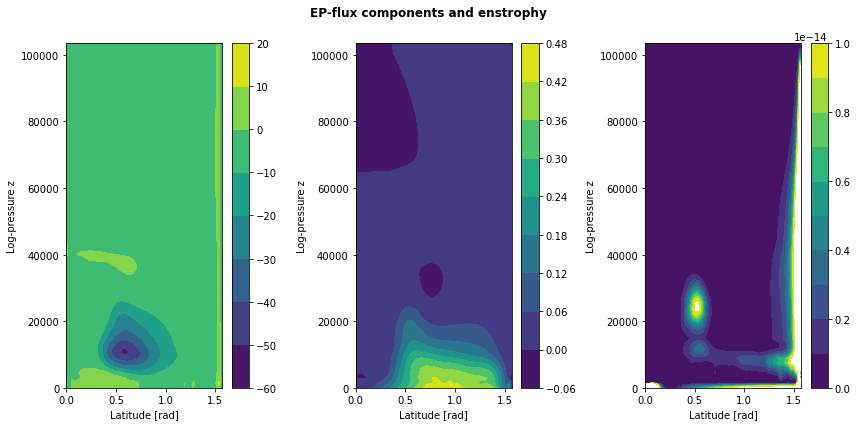

In [10]:
# plot EP-flux and enstrophy
epfy, epfz = wave.EPflux(grid,phi,basicstate['N2'].values,s)
epfy = epfy.mean(axis=0)
epfz = epfz.mean(axis=0)
enstrophy = wave.enstrophy(grid,phi,basicstate['N2'].values,s).mean(axis=0)

fig, axes = plt.subplots(1,3,figsize=(12,6))

# filled contours for 
levels = None
C = axes[0].contourf(basicstate.lat,basicstate.lev,epfy,levels=levels)
axes[0].set_ylabel('Log-pressure z')
axes[0].set_xlabel('Latitude [rad]')
plt.colorbar(C,ax=axes[0])

# filled contours for 
levels = None
C = axes[1].contourf(basicstate.lat,basicstate.lev,epfz,levels=levels)
axes[1].set_ylabel('Log-pressure z')
axes[1].set_xlabel('Latitude [rad]')
plt.colorbar(C,ax=axes[1])

# filled contours for 
levels = np.linspace(0,10**-14,11)
C = axes[2].contourf(basicstate.lat,basicstate.lev,enstrophy,levels=levels)
axes[2].set_ylabel('Log-pressure z')
axes[2].set_xlabel('Latitude [rad]')
plt.colorbar(C,ax=axes[2])

fig.suptitle('EP-flux components and enstrophy',weight='bold')
fig.tight_layout()

plt_dir = '/s2s/wwicker/plots/wavegeometry_model/'
plt.savefig(plt_dir+'IFS-pressure-level-91L_epf_enstrophy.png',dpi=300)

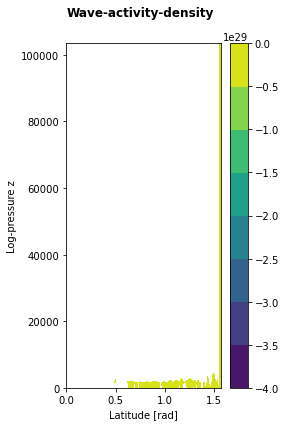

In [11]:
activity = 1/2*grid.ez * enstrophy / basicstate['qy'].values.mean(axis=0)

fig = plt.figure(figsize=(4,6))
ax = plt.axes()
C = ax.contourf(basicstate.lat,basicstate.lev,activity)
ax.set_ylabel('Log-pressure z')
ax.set_xlabel('Latitude [rad]')
plt.colorbar(C,ax=ax)

fig.suptitle('Wave-activity-density',weight='bold')
fig.tight_layout()

### Check the matrix equation

Do I have to add an additional boundary layer?